# Overview

# WORK IN PROGRESS! 

An issue was found with the 545 and 857 GHz maps. We're working on a resolution. This is preserved as-is for the time being.


Following [variance_map_ps.ipynb](variance_map_ps.ipynb), we filter anisotropic white-noise maps to induce correlations, loosely following Appendix A of Planck CO Revisited (Ghosh, S., et al.: A&A, 688, A54). The method requires data be gathered from a set of Planck's simulations:
- Covariance summary, from PCA
- Map means and standard deviations (for adjusting monopoles)
- Map units

# Imports and Parameters

In [35]:
from pathlib import Path

import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from astropy.io import fits
from astropy.cosmology import Planck15
import pysm3.units as u

from tqdm import tqdm  # For progress bars

from cmbml.utils.handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [36]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 545
RANDOM_SEED = 0
print(f"Random seed: {RANDOM_SEED}")
np.random.seed(RANDOM_SEED)
N_WHITE_NOISE_MAPS = 1

NSIDE_OUTPUT = 512
if DETECTOR in [30, 44, 70]:
    NSIDE_VAR_SOURCE = 1024
else:
    NSIDE_VAR_SOURCE = 2048

Random seed: 0


In [37]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

In [38]:
def get_field_unit(fits_fn, hdu, field_idx):
    """
    Get the unit associated with a specific field from the header of the 
    specified HDU (Header Data Unit) in a FITS file.

    Args:
        fits_fn (str): The filename of the FITS file.
        hdu (int): The index of the HDU.
        field_idx (int): The index of the field.

    Returns:
        str: The unit of the field.
    """
    with fits.open(fits_fn) as hdul:
        try:
            field_num = field_idx + 1
            unit = hdul[hdu].header[f"TUNIT{field_num}"]
        except KeyError:
            unit = ""
    return unit

# Display PS Helpers

In [39]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            white_noise_expected=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--')
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [40]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            has_planck=False):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    ells = np.arange(len(ps_s[0])).astype(float)
    if x_low < 1:
        ells[0] = x_low
    for i, ps in enumerate(ps_s):
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if has_planck and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.legend()
    plt.show()

In [41]:
def plot_many_ps_hl_one(ps_s,
                        title=None, 
                        x_low=0.7,
                        x_high=1e4,
                        y_low=1e-4,
                        y_high=1e-2,
                        styles=None,
                        labels=None,
                        white_noise_expected=None,
                        legend=True):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    ells = np.arange(len(ps_s[0])).astype(float)
    if x_low < 1:
        ells[0] = x_low
    for i, ps in enumerate(ps_s):
        style=None
        linewidth=None
        color='green'
        alpha=0.2
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if i == len(ps_s) - 1:
            color='black'
            linewidth=3
            alpha=1
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, alpha=alpha, linewidth=linewidth)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [42]:
def make_map_hist(some_map, noise_level, title=None, legend=False):
    if isinstance(some_map, list):
        for i, one_map in enumerate(some_map):
            label = f"Map {i}" if legend else None
            plt.hist(one_map, bins=100, histtype='step', label=label)
            map_unit = one_map.unit.to_string("latex_inline")
    else:
        plt.hist(some_map, bins=100, histtype='step')
        map_unit = some_map.unit.to_string("latex_inline")
    plt.axvline(noise_level.value, color='black', linestyle='--', linewidth=1)
    plt.axvline(-noise_level.value, color='black', linestyle='--', linewidth=1)
    plt.text(x=-noise_level.value, y=160000, s=f"$-\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='right')
    offset = transforms.ScaledTranslation(2/72, 0, plt.gcf().dpi_scale_trans)
    plt.text(x=noise_level.value, y=160000, s=f"$+\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transData + offset)
    plt.xlabel(map_unit)
    plt.ylabel("Pixel Count")
    if legend:
        plt.legend()
    plt.title(title)

# Gut checks for noise levels

In [43]:
# All white noise levels from Planck 2018 I, Table 4
WHITE_NOISE_LEVELS = {  # in uK_CMB deg (I'm not sure how to handle the degrees part)
    30: 2.5 * u.uK_CMB * u.deg,
    44: 2.7 * u.uK_CMB * u.deg,
    70: 3.5 * u.uK_CMB * u.deg,
    100: 1.29 * u.uK_CMB * u.deg,
    143: 0.55 * u.uK_CMB * u.deg,
    217: 0.78 * u.uK_CMB * u.deg,
    353: 2.56 * u.uK_CMB * u.deg,
    545: 0.78 * u.kJy / u.sr * u.deg,
    857: 0.72 * u.kJy / u.sr * u.deg
}

# We only need the center frequencies for the maps that are in MJy/sr
CENTER_FREQS = {
    30: 28.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    44: 44.1 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    70: 70.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    100: 100.89 * u.GHz,   # Value from Planck DeltaBandpassTable
    143: 142.876 * u.GHz,  # Value from Planck DeltaBandpassTable
    217: 221.156 * u.GHz,  # Value from Planck DeltaBandpassTable
    353: 357.5 * u.GHz,    # Value from Planck DeltaBandpassTable
    545: 555.2 * u.GHz,    # Value from Planck DeltaBandpassTable
    857: 866.8 * u.GHz,    # Value from Planck DeltaBandpassTable
}

In [44]:
def noise_level2noise_multipole(epsilon):
    """
    Convert noise level to noise multipole.
    From https://arxiv.org/pdf/2410.12951, eq 18

    Parameters
    ----------
    epsilon : float
        Noise level in uK_CMB.

    Returns
    -------
    float
        Noise at multipole.
    """
    epsilon = epsilon.to(u.uK_CMB * u.rad) ** 2
    # Drop the radian unit.
    return epsilon.value * u.uK_CMB**2


def noise_level2noise_pixel(epsilon, reso):
    # From https://arxiv.org/pdf/2410.12951, eq 20
    epsilon_pix = epsilon/reso
    return epsilon_pix


cen_freq = CENTER_FREQS[DETECTOR]
eq = u.cmb_equivalencies(cen_freq)

wht_nse_lit = WHITE_NOISE_LEVELS[DETECTOR]
if wht_nse_lit.unit == u.uK_CMB * u.deg:
    noise_planck_Karcmin = wht_nse_lit.to(u.K_CMB * u.arcmin, equivalencies=eq) #, equivalencies=u.cmb_equivalencies(CENTER_FREQS[DETECTOR]))
elif wht_nse_lit.unit == u.kJy / u.sr * u.deg:
    wht_nse_lit = wht_nse_lit.to(u.kJy / u.sr * u.arcmin)

    # Remove arcmin unit temporarily
    wht_nse_lit = wht_nse_lit.value * u.kJy / u.sr
    # wht_nse_lit = wht_nse_lit.to(u.MJy / u.sr)

    noise_planck_Karcmin = wht_nse_lit.to(u.K_CMB, equivalencies=eq)

    # Return arcmin unit
    noise_planck_Karcmin = noise_planck_Karcmin.value * u.K_CMB * u.arcmin

noise_ps_K2 = noise_level2noise_multipole(noise_planck_Karcmin)
noise_ps_uK2 = noise_ps_K2

reso_2048_arcmin = hp.nside2resol(NSIDE_VAR_SOURCE, arcmin=True) * u.arcmin
noise_px_2048_K = noise_level2noise_pixel(noise_planck_Karcmin, reso_2048_arcmin)
noise_px_2048_uK = noise_px_2048_K.to(u.uK_CMB)

reso_512_arcmin = hp.nside2resol(NSIDE_OUTPUT, arcmin=True) * u.arcmin
noise_px_512_K = noise_level2noise_pixel(noise_planck_Karcmin, reso_512_arcmin)
noise_px_512_uK = noise_px_512_K.to(u.uK_CMB)

print(f"{noise_ps_uK2:.2e}, {noise_px_2048_uK:.2e}, {noise_px_512_uK:.2e}")
print(f"{noise_ps_K2:.2e}, {noise_px_2048_K:.2e}, {noise_px_512_K:.2e}")

7.01e-02 uK_CMB2, 5.30e+02 uK_CMB, 1.33e+02 uK_CMB
7.01e-02 uK_CMB2, 5.30e-04 K_CMB, 1.33e-04 K_CMB


# Creating many anisotropic White Noise Maps at $N_{side}=512$

We first generate noise as used in CMB-ML for a full resolution map. 

In [45]:
obs_map_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)

In [46]:
# Load the source map from Planck
planck_obs_path = Path(ASSETS_DIRECTORY) / obs_map_fn
if DETECTOR in [545, 857]:
    II_cov_field = 2
else:
    II_cov_field = 4
II_cov_map = hp.read_map(planck_obs_path, hdu=1, field=II_cov_field)

assert NSIDE_VAR_SOURCE == hp.get_nside(II_cov_map)  # Make sure the map is at the correct resolution

In [47]:
def _change_variance_map_resolution(m, nside_out):
    # For variance maps, because statistics
    power = 2

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion

    return m

In [48]:
II_cov_map_512 = _change_variance_map_resolution(II_cov_map, NSIDE_OUTPUT)
assert NSIDE_OUTPUT == hp.get_nside(II_cov_map_512)  # Make sure the map is at the correct resolution

In [49]:
# Create a "scale factor" map for the noise
scale_map = np.sqrt(II_cov_map_512)  # II_cov_map contains variance values; we need standard deviation for rng.normal()

var_map_unit = get_field_unit(planck_obs_path, hdu=1, field_idx=II_cov_field)
if var_map_unit in ["Kcmb^2", "(K_CMB)^2"]:
    var_map_unit = u.K_CMB
    # TODO The next couple lines seem to have redundancies ?
    scale_map = scale_map * var_map_unit
    scale_map = u.Quantity(scale_map, unit=var_map_unit).to(u.uK_CMB)  # Convert to uK_CMB
elif var_map_unit in ["MJy/sr^2", "(Mjy/sr)^2"]:
    var_map_unit = u.MJy / u.sr
    scale_map = scale_map * var_map_unit
    eq = u.cmb_equivalencies(cen_freq)
    # TODO The next couple lines seem to have redundancies ?
    scale_map = u.Quantity(scale_map, unit=var_map_unit)
    scale_map = scale_map.to(u.uK_CMB, equivalencies=eq)  # Convert to uK_CMB
else:
    raise NotImplementedError(f"Unit {var_map_unit} not recognized.")
# Will crash for 545, 857 GHz maps

In [50]:
lmax_512 = get_lmax_for_nside(NSIDE_OUTPUT)  # Defined above as 3*Nside-1
ells_512 = np.arange(lmax_512 + 1)
# Generate the random anisotropic white-noise maps
wht_maps = []
for i in tqdm(range(N_WHITE_NOISE_MAPS)):
    rng = np.random.default_rng(RANDOM_SEED + i)
    new_wht_map = rng.normal(size=scale_map.shape) * scale_map
    wht_maps.append(new_wht_map.copy())
    del new_wht_map

100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


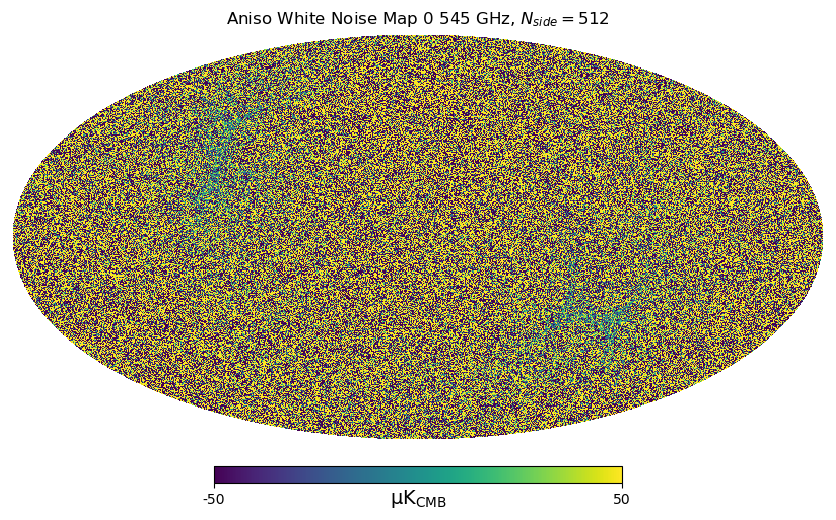

In [51]:
# Show the first two white noise maps, look for issues
for i in range(min(2, N_WHITE_NOISE_MAPS)):
    hp.mollview(wht_maps[i], unit=wht_maps[i].unit.to_string("latex_inline"),
                title=f"Aniso White Noise Map {i} {DETECTOR} GHz, " + "$N_{side}" + f"={NSIDE_OUTPUT}$",
                min=-50, max=50)
    plt.show()

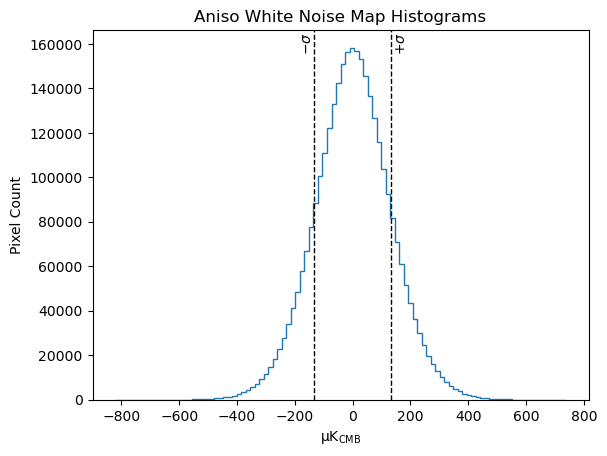

In [52]:
make_map_hist(wht_maps, noise_px_512_uK, title="Aniso White Noise Map Histograms")

# Getting Power Spectrum of Sim Noise

In [53]:
# Load pre-calculated statistics for Planck's noise simulation maps

# Load the results
data = np.load(f"noise_model_{DETECTOR}GHz_n20.npz")

src_mean_ps     = data['mean_ps']
src_components  = data['components']
src_variance    = data['variance']

src_mean_maps   = data['maps_mean']
src_sd_maps     = data['maps_sd']
src_map_unit    = data['map_unit']

src_mean_ps.shape, src_components.shape, src_variance.shape, src_mean_maps.shape, src_sd_maps.shape, src_map_unit

((6144,), (20, 6144), (20,), (), (), array('MJy/sr', dtype='<U6'))

In [54]:
src_mean_maps

array(-0.00785138, dtype=float32)

In [55]:
num_components = len(src_variance)

std_devs = np.sqrt(src_variance)
reduced_samples = np.random.normal(0, std_devs, (N_WHITE_NOISE_MAPS, num_components))

# Reconstruct power spectra in log10 space
tgt_log_ps = reduced_samples @ src_components + src_mean_ps

# Convert out of log10 space
tgt_cls = 10**tgt_log_ps

In [56]:
def make_filter(target_cl, source_cl):
    return np.sqrt(target_cl / source_cl)

In [57]:
if src_map_unit in ["Kcmb", "K_CMB"]:
    src_unit = u.K_CMB
elif src_map_unit in ["uK_CMB"]:
    src_unit = u.uK_CMB
elif src_map_unit in ["MJy/sr"]:
    src_unit = u.MJy / u.sr
else:
    raise NotImplementedError(f"Unit {src_map_unit} not recognized.")
src_unit

Unit("MJy / sr")

In [58]:
wht_maps[0].unit

Unit("uK_CMB")

In [59]:
src_mean_maps, src_sd_maps

(array(-0.00785138, dtype=float32), array(6.505619e-05, dtype=float32))

In [60]:
out_maps = []
out_ps = []

min_mean_t = (src_mean_maps - 3*src_sd_maps) * src_unit
max_mean_t = (src_mean_maps + 3*src_sd_maps) * src_unit

# for i in range(N_WHITE_NOISE_MAPS):
_wht_map = wht_maps[0]

# The monopole will have the same sign in both wht_map and output map
#   The white noise map's mean is arbitrary. We need to adjust it's sign
#   to match the sign of the target map's mean.
_subs_mean     = np.random.normal(src_mean_maps, src_sd_maps) * src_unit
_subs_sign     = np.sign(_subs_mean)
_wht_sign      = np.sign(_wht_map.mean())
if _subs_sign != _wht_sign:
    _wht_map = -_wht_map

# Now we can calculate the filter; we will need the a_lm's of the white noise
#   map, so we get the c_l from that, avoiding redundant calculations.
_wht_alm = hp.map2alm(_wht_map, lmax=lmax_512)
_wht_cl = hp.alm2cl(_wht_alm)

# We use the target cls generated above to make the filter
_tgt_cl = tgt_cls[i]
_filter = make_filter(_tgt_cl[:lmax_512+1], _wht_cl)

# Apply the filter to the white noise a_lm's
_out_alm = hp.almxfl(_wht_alm, _filter)
_new_map = hp.alm2map(_out_alm, nside=NSIDE_OUTPUT, lmax=lmax_512) * src_unit

if _new_map.mean() < min_mean_t or _new_map.mean() > max_mean_t:
    _adjusted_map = _new_map + _subs_mean - _new_map.mean()
    print(i, _new_map.mean(), _adjusted_map.mean(), _wht_map.mean())
    _new_map = _adjusted_map

_new_map = u.Quantity(_new_map, unit=src_unit)

cen_freq = CENTER_FREQS[DETECTOR]
_new_map = _new_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(cen_freq))

out_maps.append(_new_map.copy())
out_ps.append(hp.anafast(_new_map, lmax=lmax_512))

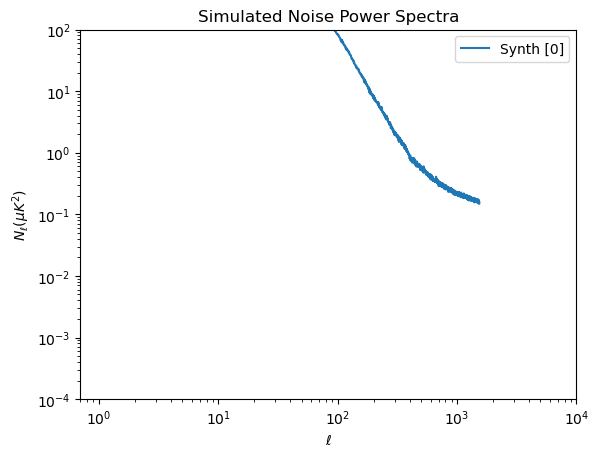

In [61]:
plot_many_ps(out_ps, 
             labels=[f"Synth [{i}]" for i in range(N_WHITE_NOISE_MAPS)],
             y_high=100,
             title="Simulated Noise Power Spectra")

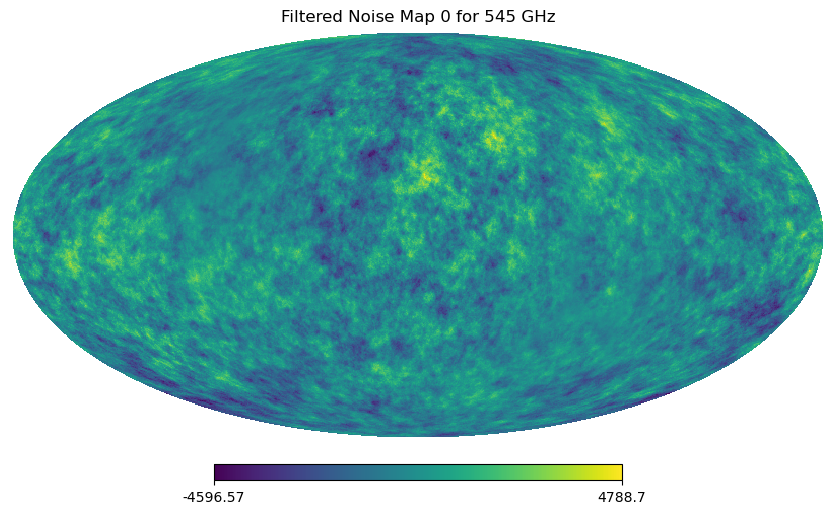

In [62]:
for i in range(min(N_WHITE_NOISE_MAPS, 10)):
    hp.mollview(out_maps[i], unit="", title=f"Filtered Noise Map {i} for {DETECTOR} GHz")  #, min=-50, max=50)

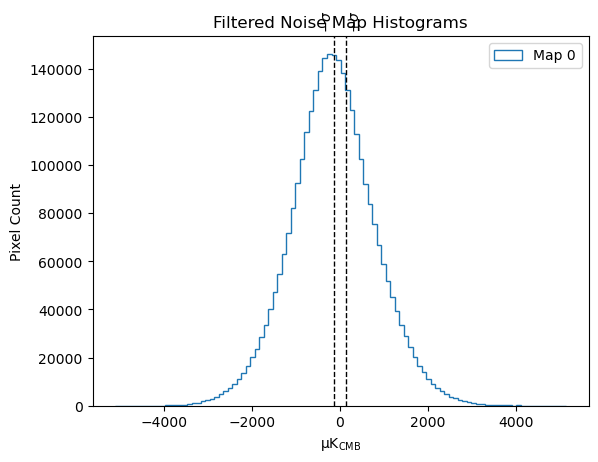

In [63]:
make_map_hist(out_maps, noise_px_512_uK, title="Filtered Noise Map Histograms", legend=True)

In [64]:
DETECTOR = 545
REAL = 0
some_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=REAL, progress=True)
some_unit = get_field_unit(some_map_fn, hdu=1, field_idx=0)
some_map0 = hp.read_map(some_map_fn, field=0)
some_map0 = some_map0 * u.Unit(some_unit)

In [65]:
REAL = 1
some_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=REAL, progress=True)
some_unit = get_field_unit(some_map_fn, hdu=1, field_idx=0)
some_map1 = hp.read_map(some_map_fn, field=0)
some_map1 = some_map1 * u.Unit(some_unit)

In [66]:
1/0

# Show first simulation
hp.mollview(some_map0, unit=some_map0.unit.to_string("latex_inline"), title=f"{DETECTOR} GHz simulation 0") #, min=-0.19, max=0.25)
plt.show()
# Show second simulation
hp.mollview(some_map1, unit=some_map1.unit.to_string("latex_inline"), title=f"{DETECTOR} GHz simulation 1", min=-0.19, max=0.25)
plt.show();

ZeroDivisionError: division by zero

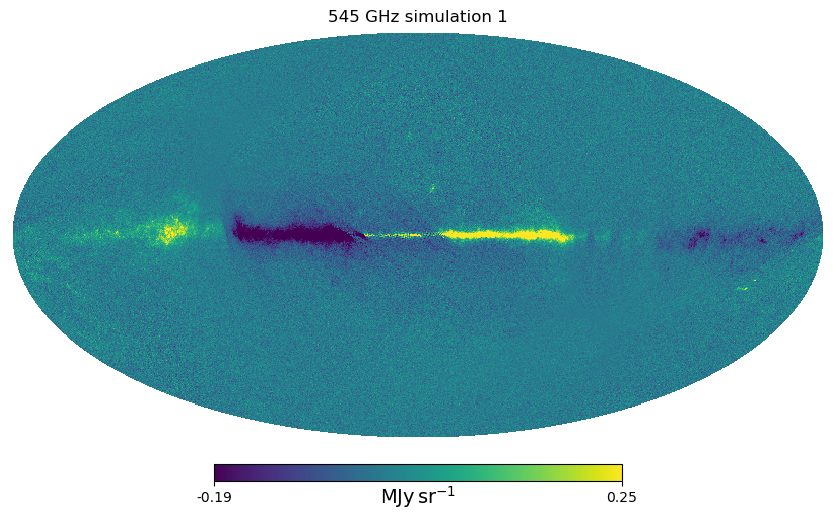

In [103]:
hp.mollview(some_map1, unit=some_map1.unit.to_string("latex_inline"), title=f"{DETECTOR} GHz simulation {REAL}", min=-0.19, max=0.25)

In [104]:
nside = hp.get_nside(some_map0)
lmax_2048 = get_lmax_for_nside(nside)
some_ps1 = hp.anafast(some_map1, lmax=lmax_2048)
some_ps0 = hp.anafast(some_map0, lmax=lmax_2048)

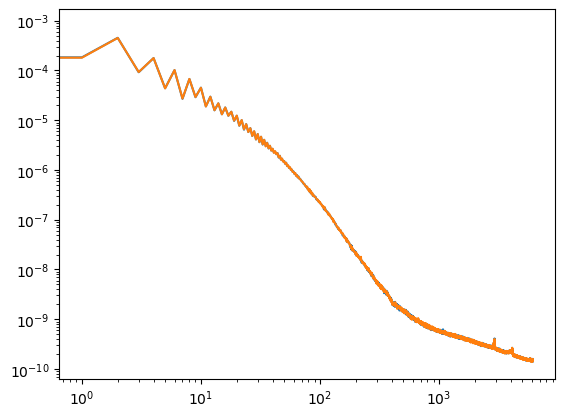

In [105]:
ells = np.arange(len(some_ps0)).astype(float)
norm = ells * (ells + 1) / (2 * np.pi)
plt.plot(some_ps0, label="0")
plt.plot(some_ps1, label="1")
plt.yscale('log')
plt.xscale('log')
plt.show()

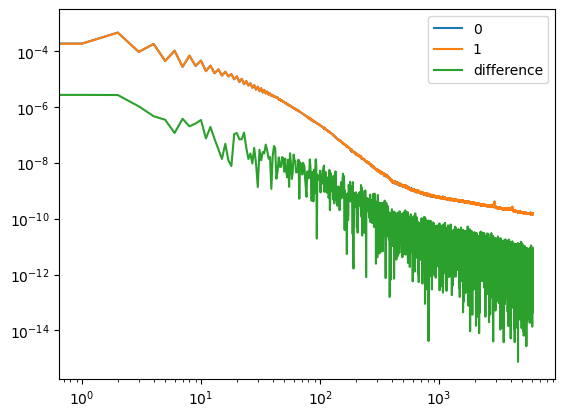

In [106]:
ells = np.arange(len(some_ps0)).astype(float)
norm = ells * (ells + 1) / (2 * np.pi)
plt.plot(some_ps0, label="0")
plt.plot(some_ps1, label="1")

plt.plot(np.abs(some_ps1 - some_ps0), label="difference")
plt.yscale('log')
plt.xscale('log')
plt.legend();

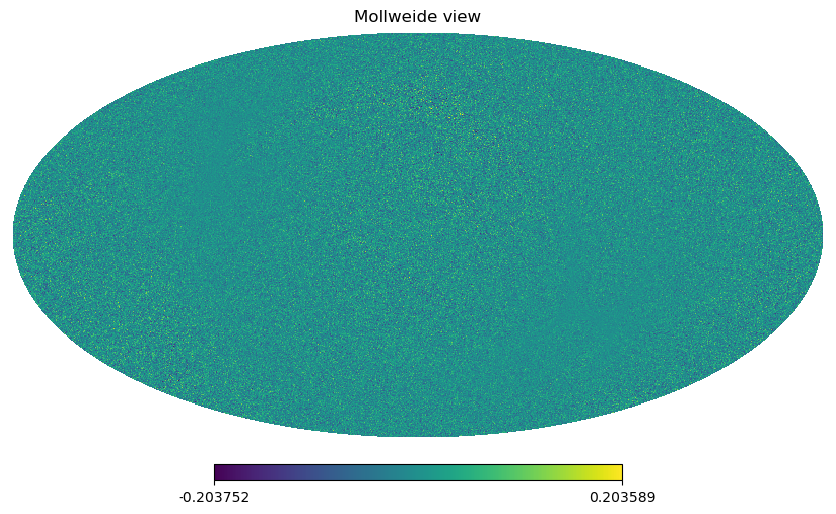

In [107]:
diff = some_map1 - some_map0
hp.mollview(diff)

In [108]:
diff_ps = hp.anafast(diff, lmax=lmax_2048)

In [109]:
plt.show()

In [110]:
diff_ps.shape

(6144,)

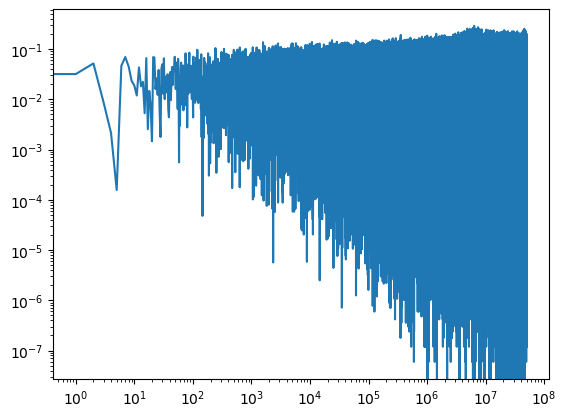

In [111]:
# plt.plot(some_ps0, label="0")
plt.plot(np.abs(diff), label="1")
# plt.plot(np.abs(some_ps1 - some_ps0), label="1")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [112]:
some_map = u.Quantity(some_map, unit=some_unit)

UnitConversionError: 'uK_CMB' and 'MJy / sr' are not convertible

In [62]:
some_map = some_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(CENTER_FREQS[DETECTOR]))

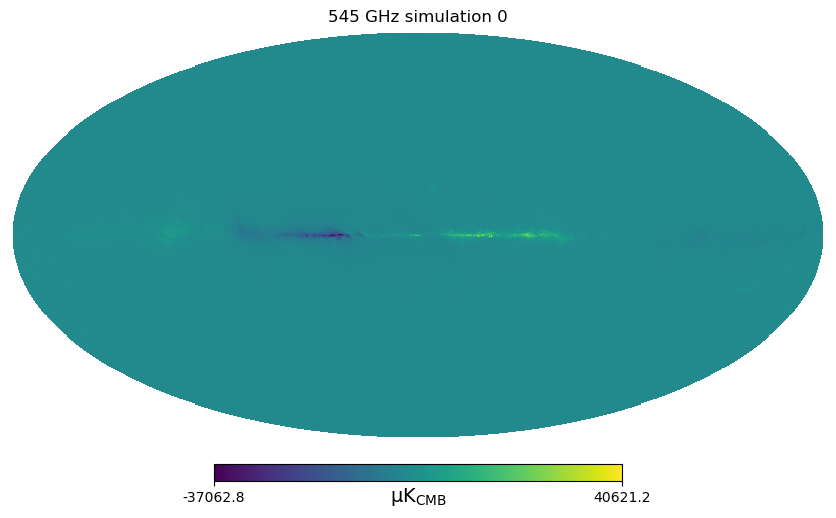

In [63]:
hp.mollview(some_map, unit=u.Unit(some_map.unit).to_string("latex_inline"), title=f"{DETECTOR} GHz simulation 0")  #, min=-3000, max=3000)